# Natural Language Processing with Disaster Tweets (v4)

ML Sample of NLP.

## Dataset

Natural Language Processing with Disaster Tweets

- Predict which Tweets are about real disasters and which ones are not
  - https://www.kaggle.com/competitions/nlp-getting-started/overview

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
STOPWORDS = stopwords.words('english')

print(STOPWORDS[:30])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself']


In [3]:
# Methods preparation
_REGEX_PATTERN_HASHTAG = r"#\w+"
_REGEX_PATTERN_URL = r"http\S+"
_REGEX_PATTERN_MENTION = r"@\w+"


def count_text_length(text: str) -> int:
    """Count the given text length."""
    return len(text)


def count_words_in_text(text: str) -> int:
    """Count the number of words in the given text."""
    return len(text.split())


def count_stopwords_in_text(text: str) -> int:
    """Count the number of stopwords in the given text."""
    return len([
        word
        for word in str(text).lower().split()
        if word in STOPWORDS
    ])


def count_hashtags_in_text(text: str) -> int:
    """Count the number of hashtags in the given text."""
    return len([
        word
        for word in text.split()
        if re.fullmatch(_REGEX_PATTERN_HASHTAG, word)
    ])


def count_urls_in_text(text: str) -> int:
    """Count the number of URLs in the given text."""
    return len([
        word
        for word in text.split()
        if re.fullmatch(_REGEX_PATTERN_URL, word)
    ])


def count_mentions_in_text(text: str) -> int:
    """Count the number of mentions in the given text."""
    return len([
        word
        for word in text.split()
        if re.fullmatch(_REGEX_PATTERN_MENTION, word)
    ])


def clean_text(text: str) -> str:
    """Clean text with remove hashtag, user name, and URL."""
    text = re.sub(_REGEX_PATTERN_HASHTAG, "", text)
    text = re.sub(_REGEX_PATTERN_URL, "", text)
    text = re.sub(_REGEX_PATTERN_MENTION, "", text)
    return text


def fill_missing_keyword_and_location(df: pd.DataFrame) -> None:
    """Complete missing values in the 'keyword' and 'location' columns of a DataFrame."""
    df['keyword'].fillna('unknown_keyword', inplace=True)
    df['location'].fillna('unknown_location', inplace=True)

In [4]:
# Load Train Dataset
df_train = pd.read_csv("./raw_data/train.csv")

df_train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [5]:
# EDA: count text length
df_train['text_length'] = df_train['text'].apply(count_text_length)

print(df_train['text_length'].head())

0     69
1     38
2    133
3     65
4     88
Name: text_length, dtype: int64


In [6]:
# EDA: count words
df_train['words_count'] = df_train['text'].apply(count_words_in_text)

print(df_train['words_count'].head())

0    13
1     7
2    22
3     8
4    16
Name: words_count, dtype: int64


In [7]:
# EDA: count stopwords
df_train['stopwords_count'] = df_train['text'].apply(count_stopwords_in_text)

print(df_train['stopwords_count'].head())

0     6
1     0
2    11
3     1
4     7
Name: stopwords_count, dtype: int64


In [8]:
# EDA: count hashtags
df_train['hashtags_count'] = df_train['text'].apply(count_hashtags_in_text)

print(df_train['hashtags_count'])

_count_result = sum(df_train['hashtags_count'].value_counts().loc[lambda x: x.index > 0])
print(f"The number of count debbug: {_count_result}")

0       1
1       0
2       0
3       1
4       2
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: hashtags_count, Length: 7613, dtype: int64
The number of count debbug: 1633


In [9]:
# EDA: count URLs
df_train['urls_count'] = df_train['text'].apply(count_urls_in_text)

print(df_train['urls_count'])

_count_result = sum(df_train['urls_count'].value_counts().loc[lambda x: x.index > 0])
print(f"The number of count debbug: {_count_result}")

0       0
1       0
2       0
3       0
4       0
       ..
7608    1
7609    0
7610    1
7611    0
7612    1
Name: urls_count, Length: 7613, dtype: int64
The number of count debbug: 3963


In [10]:
# EDA: count mentions
df_train['mentions_count'] = df_train['text'].apply(count_mentions_in_text)

print(df_train['mentions_count'])

_count_result = sum(df_train['mentions_count'].value_counts().loc[lambda x: x.index > 0])
print(f"The number of count debbug: {_count_result}")

0       0
1       0
2       0
3       0
4       0
       ..
7608    0
7609    2
7610    0
7611    0
7612    0
Name: mentions_count, Length: 7613, dtype: int64
The number of count debbug: 1884


In [11]:
META_FEATURES = [
    'text_length',
    'words_count',
    'stopwords_count',
    'hashtags_count',
    'urls_count',
    'mentions_count',
]

In [12]:
is_disaster_tweets: bool = df_train['target'] == 1

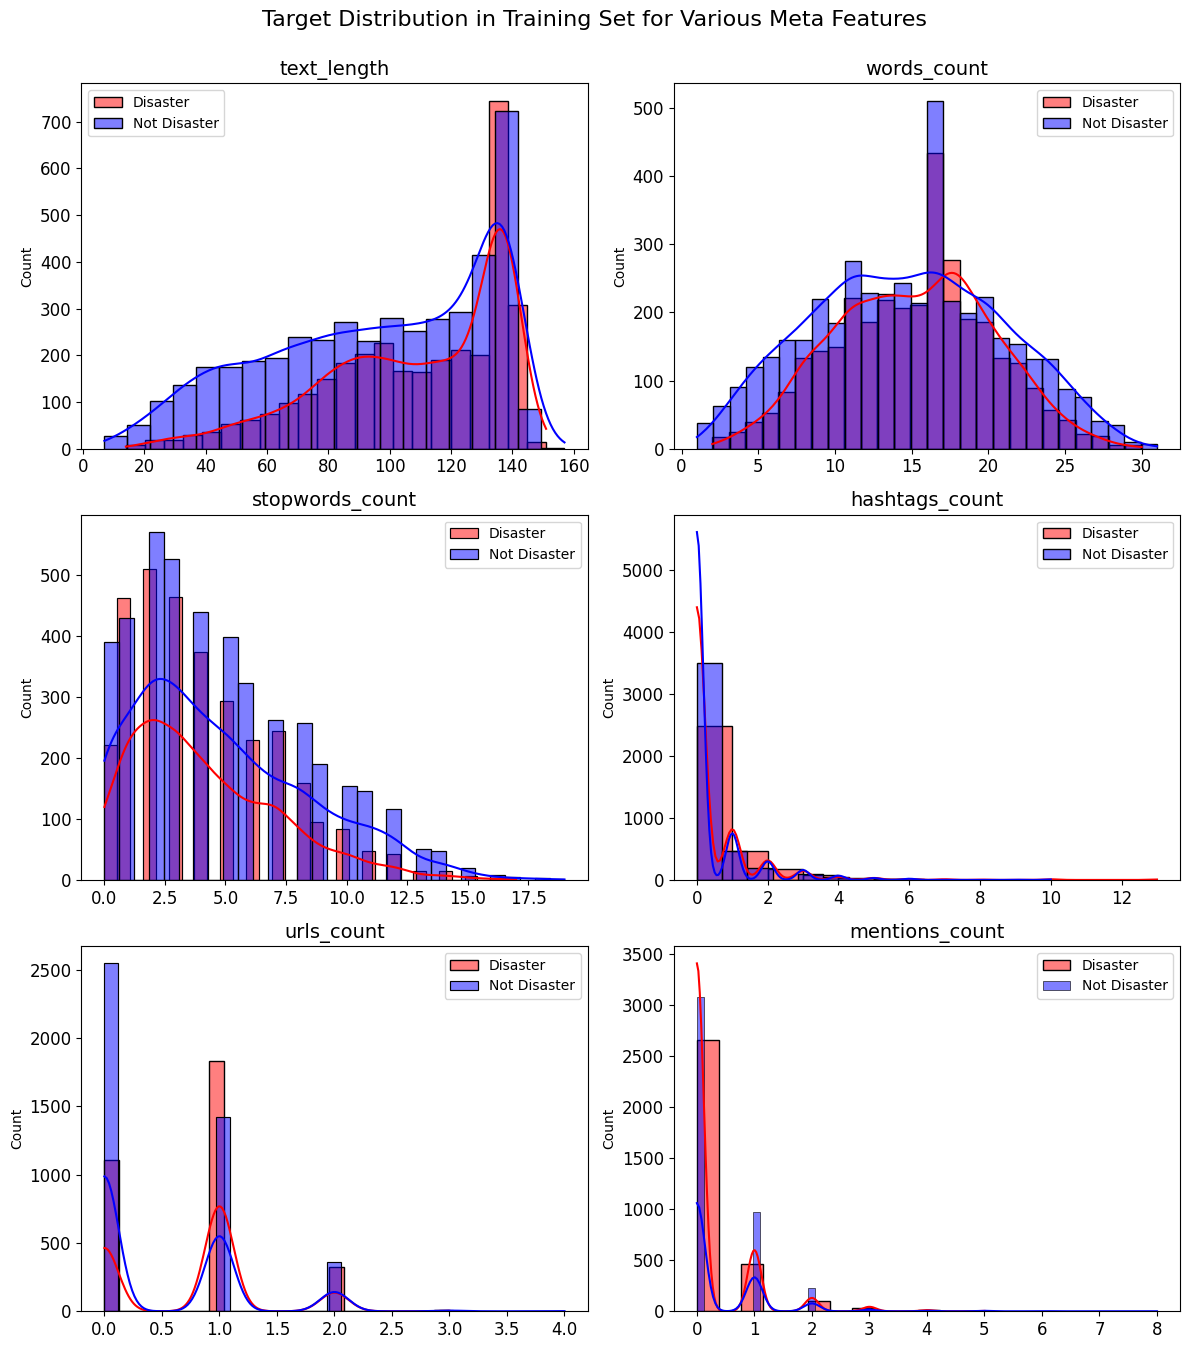

In [13]:
# Plot Target Distribution in Training Set for Various Meta Features
fig, axes = plt.subplots(
    nrows=(int(len(META_FEATURES) / 2) + (len(META_FEATURES) % 2 > 0)),
    ncols=2,
    figsize=(12, 14)
)
fig.suptitle(
    'Target Distribution in Training Set for Various Meta Features',
    fontsize=16
)
axes = axes.flatten()

for i, feature in enumerate(META_FEATURES):
    # Compare the distribution of disaster tweets and non-disaster tweets (perform kernel density estimation)
    sns.histplot(
        df_train.loc[is_disaster_tweets, feature],
        label='Disaster',
        ax=axes[i],
        color='red',
        kde=True
    )
    sns.histplot(
        df_train.loc[~is_disaster_tweets, feature],
        label='Not Disaster',
        ax=axes[i],
        color='blue',
        kde=True
    )
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    axes[i].set_title(feature, fontsize=14)

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()

- There does not appear to be a significant difference in distribution between disaster and non-disaster tweets.

In [14]:
# Preprocessing: fill NaN and clean text

# FIXME: temporary comment out

# fill_missing_keyword_and_location(df_train)
# df_train['text'] = df_train['text'].apply(clean_text)

df_train

,id,keyword,location,text,target,text_length,words_count,stopwords_count,hashtags_count,urls_count,mentions_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,6,1,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,11,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,7,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11,2,0,1,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,20,9,0,0,2
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8,2,0,1,0
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,19,5,0,0,0
